<a href="https://colab.research.google.com/github/v-artur/Golden_Oreos/blob/main/speaker_indep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORTANT: In order to access our files stored in Google Drive, you need to visit the following link: https://drive.google.com/drive/folders/1Qfr8TNZSlrhpKgYx0LrTxve9ljIFwqRq?usp=sharing

Then, click on the "DeepLearning" folder just beneath the search bar, then select "Add shortcut to Drive", then select "My Drive" and create a shortcut. After that, you should be able to see our folder and the files within when you are mounting your drive. The paths to the files in the code should work as inteded, but we can't cross out the possibility that you might need to change some filepaths (it worked for us and we also tested it with our other 3rd party accounts). If you have any questions or something does not work, please contact us.

# Loading the data

In [ ]:
%%capture
!pip install fastdtw
!pip install pysptk
!pip install pyworld

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shutil
# Copying the modules into the base directory
shutil.copyfile("/content/drive/MyDrive/DeepLearning/MelFilterBank.py", "/content/MelFilterBank.py")
shutil.copyfile("/content/drive/MyDrive/DeepLearning/reconstructWave.py", "/content/reconstructWave.py")

'/content/reconstructWave.py'

In [ ]:
import reconstructWave as rW
import MelFilterBank as mel

## Obtaining the sets ver.1 (outdated)

In [ ]:
# # Obtaining the data and the modules

# # AE data
# #train set
# !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1-HYBWzVl-Ofysa7ymqKjwbTwKYxhFrQA' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1-HYBWzVl-Ofysa7ymqKjwbTwKYxhFrQA" -O train.pkl && rm -rf /tmp/cookies.txt
# #validation set
# !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1tuEJ2pPgm09KgXhmscXErp9zUMfg09mK' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1tuEJ2pPgm09KgXhmscXErp9zUMfg09mK" -O val.pkl && rm -rf /tmp/cookies.txt
# #test set
# !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=14PnH-er4KYUnDPyOGL5Cz8X5V6KS6yGB' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=14PnH-er4KYUnDPyOGL5Cz8X5V6KS6yGB" -O test.pkl && rm -rf /tmp/cookies.txt

# # Incremental PCA data
# #train set
# !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1OLL8rETVIaifkeWioA6mKOa6u6ewO-J1' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1OLL8rETVIaifkeWioA6mKOa6u6ewO-J1" -O train_v2.pkl && rm -rf /tmp/cookies.txt
# #validation set
# !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1-AvUTiOpPFibKnzZYpKGbn33rNZJJYst' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1-AvUTiOpPFibKnzZYpKGbn33rNZJJYst" -O val_v2.pkl && rm -rf /tmp/cookies.txt
# #test set
# !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1-GL33jBvYeB5sRnWnnHtroEBE9hdwpyh' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1-GL33jBvYeB5sRnWnnHtroEBE9hdwpyh" -O test_v2.pkl && rm -rf /tmp/cookies.txt


# #reconstruction module
# !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1_eeG0d_r-RqazUkr-ZRPNC6L13sHYwIP' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1_eeG0d_r-RqazUkr-ZRPNC6L13sHYwIP" -O reconstructWave.py && rm -rf /tmp/cookies.txt
# #Melfiltebank applier
# !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Bjf3ncRe8CcWHl3i0HxRo4unRYkz2fog' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1Bjf3ncRe8CcWHl3i0HxRo4unRYkz2fog" -O MelFilterBank.py && rm -rf /tmp/cookies.txt


In [ ]:
# # Extracting the data from the AE model
# import pickle

# # Train
# with open('train.pkl', 'rb') as f:
#   obj = pickle.load(f)
#   X_train, y_train = obj[0], obj[1]

# # Validation
# with open('val.pkl', 'rb') as f:
#   obj = pickle.load(f)
#   X_val, y_val = obj[0], obj[1]

# # Test
# with open('test.pkl', 'rb') as f:
#   obj = pickle.load(f)
#   X_test, y_test = obj[0], obj[1]

In [ ]:
# # Extracting the data from the Incremental PCA model
# import pickle

# # Train
# with open('train_v2.pkl', 'rb') as f:
#   obj = pickle.load(f)
#   X_train2, y_train2 = obj[0], obj[1]

# # Validation
# with open('val_v2.pkl', 'rb') as f:
#   obj = pickle.load(f)
#   X_val2, y_val2 = obj[0], obj[1]

# # Test
# with open('test_v2.pkl', 'rb') as f:
#   obj = pickle.load(f)
#   X_test2, y_test2 = obj[0], obj[1]

## Obtaining the sets ver.2

If previous one does not work:

In [ ]:
# Extracting the data from the AE model
import pickle

# Train
with open('/content/drive/MyDrive/DeepLearning/train.pkl', 'rb') as f:
  obj = pickle.load(f)
  X_train, y_train = obj[0], obj[1]

# Validation
with open('/content/drive/MyDrive/DeepLearning/val.pkl', 'rb') as f:
  obj = pickle.load(f)
  X_val, y_val = obj[0], obj[1]

# Test
with open('/content/drive/MyDrive/DeepLearning/test.pkl', 'rb') as f:
  obj = pickle.load(f)
  X_test, y_test = obj[0], obj[1]

In [ ]:
# Extracting the data from the Incremental PCA model

# Train
with open('/content/drive/MyDrive/DeepLearning/train_v2.pkl', 'rb') as f:
  obj = pickle.load(f)
  X_train2, y_train2 = obj[0], obj[1]

# Validation
with open('/content/drive/MyDrive/DeepLearning/val_v2.pkl', 'rb') as f:
  obj = pickle.load(f)
  X_val2, y_val2 = obj[0], obj[1]

# Test
with open('/content/drive/MyDrive/DeepLearning/test_v2.pkl', 'rb') as f:
  obj = pickle.load(f)
  X_test2, y_test2 = obj[0], obj[1]

In [ ]:
X_train.shape

(179011, 350)

In [ ]:
X_train2.shape

(179011, 250)

# Modeling

In [ ]:
# Setting seed
import tensorflow as tf
tf.keras.utils.set_random_seed(1234)

In [ ]:
from tensorflow.keras import regularizers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, Input, Flatten
import numpy as np
from sklearn.metrics import mean_squared_error as mse

# baseline FC-DNN model
def create_dnn_model(inputsize, outputsize):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(inputsize)))
    model.add(tf.keras.layers.Dense(300, activation="relu", kernel_initializer='HeNormal'))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(150, activation="relu", kernel_initializer='HeNormal'))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(50, activation="relu", kernel_initializer='HeNormal'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(25, activation="relu", kernel_initializer='HeNormal'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(outputsize))
    return model

In [ ]:
from scipy.stats import pearsonr

def pearson_corr(preds, y):
  rs = np.zeros((y.shape[1]))

  # Evaluate reconstruction of this fold
  for specBin in range(y.shape[1]):
    r, p = pearsonr(y[:, specBin], preds[:, specBin])
    rs[specBin] = r

  #Show evaluation result
  print('Mean correlation:', np.mean(rs))

FC-DNN

With the the data from the AE model:

In [ ]:
early_stopping = EarlyStopping(patience=10, verbose=1, min_delta=1e-5)
checkpointer = ModelCheckpoint(filepath='weights_fcdnn_1.hdf5', save_best_only=True, verbose=1)

model = create_dnn_model(X_train.shape[1], 23)
model.compile(loss='mse', optimizer='adam', metrics=['mse'])
model.fit(X_train, y_train, batch_size=256, 
          epochs=100, verbose=1, validation_data=(X_val, y_val), shuffle=True,
          callbacks=[checkpointer, early_stopping])

Epoch 1/100
683/700 [============================>.] - ETA: 0s - loss: 7.2159 - mse: 7.2159
Epoch 1: val_loss improved from inf to 4.85558, saving model to weights_fcdnn_1.hdf5
700/700 [==============================] - 6s 4ms/step - loss: 7.1676 - mse: 7.1676 - val_loss: 4.8556 - val_mse: 4.8556
Epoch 2/100
693/700 [============================>.] - ETA: 0s - loss: 5.1735 - mse: 5.1735
Epoch 2: val_loss improved from 4.85558 to 4.82994, saving model to weights_fcdnn_1.hdf5
700/700 [==============================] - 2s 3ms/step - loss: 5.1722 - mse: 5.1722 - val_loss: 4.8299 - val_mse: 4.8299
Epoch 3/100
685/700 [============================>.] - ETA: 0s - loss: 5.0478 - mse: 5.0478
Epoch 3: val_loss improved from 4.82994 to 4.80851, saving model to weights_fcdnn_1.hdf5
700/700 [==============================] - 2s 3ms/step - loss: 5.0481 - mse: 5.0481 - val_loss: 4.8085 - val_mse: 4.8085
Epoch 4/100
694/700 [============================>.] - ETA: 0s - loss: 4.9948 - mse: 4.9948
Epoch 

In [ ]:
model.load_weights('weights_fcdnn_1.hdf5')
model.evaluate(X_test, y_test)

1865/1865 [==============================] - 3s 2ms/step - loss: 4.6751 - mse: 4.6751


[4.675112724304199, 4.675112724304199]

In [ ]:
preds1 = model.predict(X_test)
pearson_corr(preds1, y_test)

1865/1865 [==============================] - 2s 1ms/step
Mean correlation: -0.0026370086136995583


In [ ]:
print('RMSE:', mse(y_test, preds1)**0.5)

RMSE: 2.162200527793178


With the data from the Incremental PCA model:

In [ ]:
early_stopping = EarlyStopping(patience=10, verbose=1, min_delta=1e-5)
checkpointer = ModelCheckpoint(filepath='weights_fcdnn_2.hdf5', save_best_only=True, verbose=1)

model = create_dnn_model(X_train2.shape[1], 23)
model.compile(loss='mse', optimizer='adam', metrics=['mse'])
model.fit(X_train2, y_train2, batch_size=256, 
          epochs=100, verbose=1, validation_data=(X_val2, y_val2), shuffle=True,
          callbacks=[checkpointer, early_stopping])

Epoch 1/100
699/700 [============================>.] - ETA: 0s - loss: 7.1340 - mse: 7.1340
Epoch 1: val_loss improved from inf to 4.15364, saving model to weights_fcdnn_2.hdf5
700/700 [==============================] - 3s 4ms/step - loss: 7.1325 - mse: 7.1325 - val_loss: 4.1536 - val_mse: 4.1536
Epoch 2/100
692/700 [============================>.] - ETA: 0s - loss: 3.4758 - mse: 3.4758
Epoch 2: val_loss improved from 4.15364 to 3.35514, saving model to weights_fcdnn_2.hdf5
700/700 [==============================] - 2s 3ms/step - loss: 3.4727 - mse: 3.4727 - val_loss: 3.3551 - val_mse: 3.3551
Epoch 3/100
689/700 [============================>.] - ETA: 0s - loss: 2.8636 - mse: 2.8636
Epoch 3: val_loss improved from 3.35514 to 2.53361, saving model to weights_fcdnn_2.hdf5
700/700 [==============================] - 2s 3ms/step - loss: 2.8587 - mse: 2.8587 - val_loss: 2.5336 - val_mse: 2.5336
Epoch 4/100
690/700 [============================>.] - ETA: 0s - loss: 2.5605 - mse: 2.5605
Epoch 

In [ ]:
model.load_weights('weights_fcdnn_2.hdf5')
model.evaluate(X_test2, y_test2)

1865/1865 [==============================] - 3s 2ms/step - loss: 2.2129 - mse: 2.2129


[2.2128682136535645, 2.2128682136535645]

In [ ]:
preds2 = model.predict(X_test2)
pearson_corr(preds2, y_test2)

1865/1865 [==============================] - 2s 1ms/step
Mean correlation: 0.725819425228279


In [ ]:
print('RMSE:', mse(y_test2, preds2)**0.5)

RMSE: 1.4875708887747754


## Optimizing

Since the Incremental PCA baseline performed much better than the one trained on the AutoEncoder data, the optimization was only performed on the former.

In [ ]:
%%capture
!pip install keras-tuner

In [ ]:
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
import scipy.io.wavfile as wavfile

### FC-DNN

In [ ]:
#!rm -r synth_audio_fcdnn_opt
!mkdir synth_audio_fcdnn_opt

In [ ]:
def create_dnn_model_opt(hp):  

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Input(shape=(250)))

  # 1st Layer
  hp_units_1 = hp.Int('units_1', min_value=100, max_value=150, step=10)
  model.add(tf.keras.layers.Dense(units = hp_units_1, activation="relu", kernel_initializer='HeNormal'))
  model.add(tf.keras.layers.Dropout(rate=hp.Float('dropout_1', min_value = 0.0, max_value = 0.2, default = 0.1, step = 0.04)))

  # 2nd Layer
  hp_units_2 = hp.Int('units_2', min_value=100, max_value=140, step=10)
  model.add(tf.keras.layers.Dense(units = hp_units_2, activation="relu", kernel_initializer='HeNormal'))
  model.add(tf.keras.layers.Dropout(rate=hp.Float('dropout_2', min_value = 0.0, max_value = 0.2, default = 0.1, step = 0.04)))

  # 3rd Layer
  hp_units_3 = hp.Int('units_3', min_value=60, max_value=80, step=5)
  model.add(tf.keras.layers.Dense(units = hp_units_3, activation="relu", kernel_initializer='HeNormal'))
  model.add(tf.keras.layers.Dropout(rate=hp.Float('dropout_3', min_value = 0.0, max_value = 0.2, default = 0.1, step = 0.04)))

  # Final Layers
  model.add(tf.keras.layers.Dense(40))
  model.add(tf.keras.layers.Dense(23)) #output

  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='mse',
                metrics=['mse'])
  
  return model

In [ ]:
#Tuning the hyperparameters
tuner = kt.Hyperband(create_dnn_model_opt,
                         objective='val_loss',
                         max_epochs=10,
                         factor=2,
                         directory='/content/fcdnn_opt',
                         project_name='dnn_opt')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
tuner.search(X_train2, y_train2, epochs=100, batch_size=64, validation_data=(X_val2, y_val2), verbose=0, shuffle=True, callbacks=[stop_early])
best_hps = tuner.get_best_hyperparameters(num_trials=3)[0]

In [ ]:
#Applying the best model
early_stopping = EarlyStopping(patience=10, verbose=1, min_delta=1e-5)
checkpointer = ModelCheckpoint(filepath='weights_fcdnn_opt.hdf5', save_best_only=True, verbose=1)

model = tuner.hypermodel.build(best_hps)

model.fit(X_train2, y_train2, batch_size=64, 
                  epochs=100, verbose=0, validation_data=(X_val2, y_val2), shuffle=True,
                  callbacks=[checkpointer, early_stopping])


Epoch 1: val_loss improved from inf to 2.22864, saving model to weights_fcdnn_opt.hdf5

Epoch 2: val_loss improved from 2.22864 to 2.19507, saving model to weights_fcdnn_opt.hdf5

Epoch 3: val_loss improved from 2.19507 to 2.16042, saving model to weights_fcdnn_opt.hdf5

Epoch 4: val_loss did not improve from 2.16042

Epoch 5: val_loss did not improve from 2.16042

Epoch 6: val_loss did not improve from 2.16042

Epoch 7: val_loss did not improve from 2.16042

Epoch 8: val_loss did not improve from 2.16042

Epoch 9: val_loss did not improve from 2.16042

Epoch 10: val_loss did not improve from 2.16042

Epoch 11: val_loss did not improve from 2.16042

Epoch 12: val_loss did not improve from 2.16042

Epoch 13: val_loss did not improve from 2.16042
Epoch 13: early stopping


In [ ]:
#predict with the best weights
model.load_weights('weights_fcdnn_opt.hdf5')
preds_fcdnn = model.predict(X_test2, verbose=0)

print(model.evaluate(X_test2, y_test2))
print('Pearson correlation: ',pearson_corr(preds_fcdnn, y_test2))
print('RMSE: ', mse(y_test2, preds2)**0.5)

1865/1865 [==============================] - 3s 2ms/step - loss: 2.1437 - mse: 2.1437
[2.1437294483184814, 2.1437294483184814]
Mean correlation: 0.7329190816455542
Pearson correlation:  None
RMSE:  1.4875708887747754


## MCD

In [ ]:
#For audio reconstruction and MCD measure 
#dependencies
import librosa
from scipy.io import wavfile
import pysptk
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

# functions for MCD calculations 
# (source: https://github.com/ttslr/python-MCD?fbclid=IwAR2OFaz3-8kTfhJXC7F-cmTTHkY-egEzZdSYHsC0agwPw58N2G3hqhfdVNY)


#The following function converts the spectrogram into an mgc format which can be used to evaluate the MCD score
def readmgc(x, sr):
    assert sr == 16000
    x = x.astype(np.float64)
    frame_length = 1024
    hop_length = 256  
    frames = librosa.util.frame(x, frame_length=frame_length, hop_length=hop_length).astype(np.float64).T
    frames *= pysptk.blackman(frame_length)
    assert frames.shape[1] == frame_length 
    order = 25
    alpha = 0.41
    stage = 5
    gamma = -1.0 / stage

    mgc = pysptk.mgcep(frames, order, alpha, gamma)
    mgc = mgc.reshape(-1, order + 1)
    return mgc

# Calculating the MCD of two given mgc-s
def calculations(x, y): 

    #computational parameters
    _logdb_const = 10.0 / np.log(10.0) * np.sqrt(2.0)
    s = 0.0
    framesTot = 0

    # The calculations
    distance, path = fastdtw(x, y, dist=euclidean)

    distance/= (len(x) + len(y))
    pathx = list(map(lambda l: l[0], path))
    pathy = list(map(lambda l: l[1], path))
    x, y = x[pathx], y[pathy]

    frames = x.shape[0]
    framesTot  += frames

    z = x - y
    s += np.sqrt((z * z).sum(-1)).sum()
    MCD_value = _logdb_const * float(s) / float(framesTot)

    return MCD_value


# This function returns the average MCD score for the BiGRU and the Convolutional model
def compute_mcd(spec_orig, spec_fcdnn, sr):

  # Computing the mgc of the original spectrogram
  mgc_orig = readmgc(spec_orig, sr)
  print('Successfully read the original spectrogram')
  
  # Computing the mgc of the synthesized spectrograms
  mgc_fcdnn = readmgc(spec_fcdnn, sr)
  print('Successfully read the FC-DNN spectrogram')

  fcdnn_mcd = calculations(mgc_orig, mgc_fcdnn)
  
  return fcdnn_mcd


#Small helping function to filter out NaNs and infintes during the audio reconstruction
def makeNormal(x):
        nanIdx = np.isnan(x)
        x[nanIdx] = 0
        
        infIdx = np.isinf(x)
        x[infIdx] = 0

        return x

#Reconstructing the WAV file from the predicted mel-log spectrogram (modified Griffin-Lim method)
def createAudio(spectrogram, audiosr=16000, winLength=0.05, frameshift=0.01):
    mfb = mel.MelFilterBank(int((audiosr*winLength)/2+1), spectrogram.shape[1], audiosr)
    hop = int(spectrogram.shape[0])
    rec_audio = np.array([])
    # we needed to change the exponential function to power function otherwise sometimes it produces faulty spectograms
    for_reconstruction = makeNormal(np.dot(np.power(spectrogram, 4), mfb.melInvMatrix))
    for w in range(0,spectrogram.shape[0],hop):
        spec = for_reconstruction[w:min(w+hop,for_reconstruction.shape[0]),:]
        rec = rW.reconstructWavFromSpectrogram(spec,spec.shape[0]*spec.shape[1],fftsize=int(audiosr*winLength),overlap=int(winLength/frameshift))
        rec_audio = np.append(rec_audio,rec)
    scaled = np.int16(rec_audio/np.max(np.abs(rec_audio)) * 32767)
    return scaled


In [ ]:
import matplotlib.pyplot as plt
import pyworld

In [ ]:
#Audio Reconstruction parameters
winLength = 0.05
frameshift = 0.01
audiosr = 16000

In [ ]:
#source: https://github.com/SamuelBroughton/Mel-Cepstral-Distortion/blob/master/mel-cepstral-distortion.ipynb
def load_wav(wav_file, sr):
    """
    Load a wav file with librosa.
    :param wav_file: path to wav file
    :param sr: sampling rate
    :return: audio time series numpy array
    """
    wav, _ = librosa.load(wav_file, sr=sr, mono=True)

    return wav

In [ ]:
#!rm -r synth_audio_fcdnn
!mkdir synth_audio_fcdnn
!mkdir synth_audio_true

In [ ]:
import os
rec_fcdnn = createAudio(preds_fcdnn, audiosr=audiosr, winLength=winLength, frameshift=frameshift)
wavfile.write(os.path.join('/content/synth_audio_fcdnn/predicted.wav'), int(audiosr), rec_fcdnn)

rec_true = createAudio(y_test, audiosr=audiosr, winLength=winLength, frameshift=frameshift)
wavfile.write(os.path.join('/content/synth_audio_true/true.wav'), int(audiosr), rec_true)

In [ ]:
# Finally, calculating the MCD for both models
# We average over the 10 parts of the spectrograms which belong to different subjects 
# (This is faster and yields the same results as if we did it on the whole spectrograms)

fcdnn_all = 0

for i in range(10):
  print('Epoch: ', i+1)
  fcdnn_mcd = compute_mcd(rec_true[int(len(rec_true)*i/10):int(len(rec_true)*(i+1)/10)],
                          rec_fcdnn[int(len(rec_fcdnn)*i/10):int(len(rec_fcdnn)*(i+1)/10)],
                          16000)
  fcdnn_all += fcdnn_mcd

print('The average MCD of the FC-DNN model: ', fcdnn_all/10)

Epoch:  1
Successfully read the original spectrogram
Successfully read the FC-DNN spectrogram
Epoch:  2
Successfully read the original spectrogram
Successfully read the FC-DNN spectrogram
Epoch:  3
Successfully read the original spectrogram
Successfully read the FC-DNN spectrogram
Epoch:  4
Successfully read the original spectrogram
Successfully read the FC-DNN spectrogram
Epoch:  5
Successfully read the original spectrogram
Successfully read the FC-DNN spectrogram
Epoch:  6
Successfully read the original spectrogram
Successfully read the FC-DNN spectrogram
Epoch:  7
Successfully read the original spectrogram
Successfully read the FC-DNN spectrogram
Epoch:  8
Successfully read the original spectrogram
Successfully read the FC-DNN spectrogram
Epoch:  9
Successfully read the original spectrogram
Successfully read the FC-DNN spectrogram
Epoch:  10
Successfully read the original spectrogram
Successfully read the FC-DNN spectrogram
The average MCD of the FC-DNN model:  1.236176998440652


In [ ]:
# Sample from the original and the reconstructed wav
from IPython.display import Audio 
Audio(rec_fcdnn[:500000], rate=16000)

In [ ]:
Audio(rec_true[:500000], rate=16000)

In [ ]:
#loading the wavfiles
orig = load_wav('/content/synth_audio_true/true.wav', 16000)
rec_fcdnn = load_wav('/content/synth_audio_fcdnn/predicted.wav', 16000)

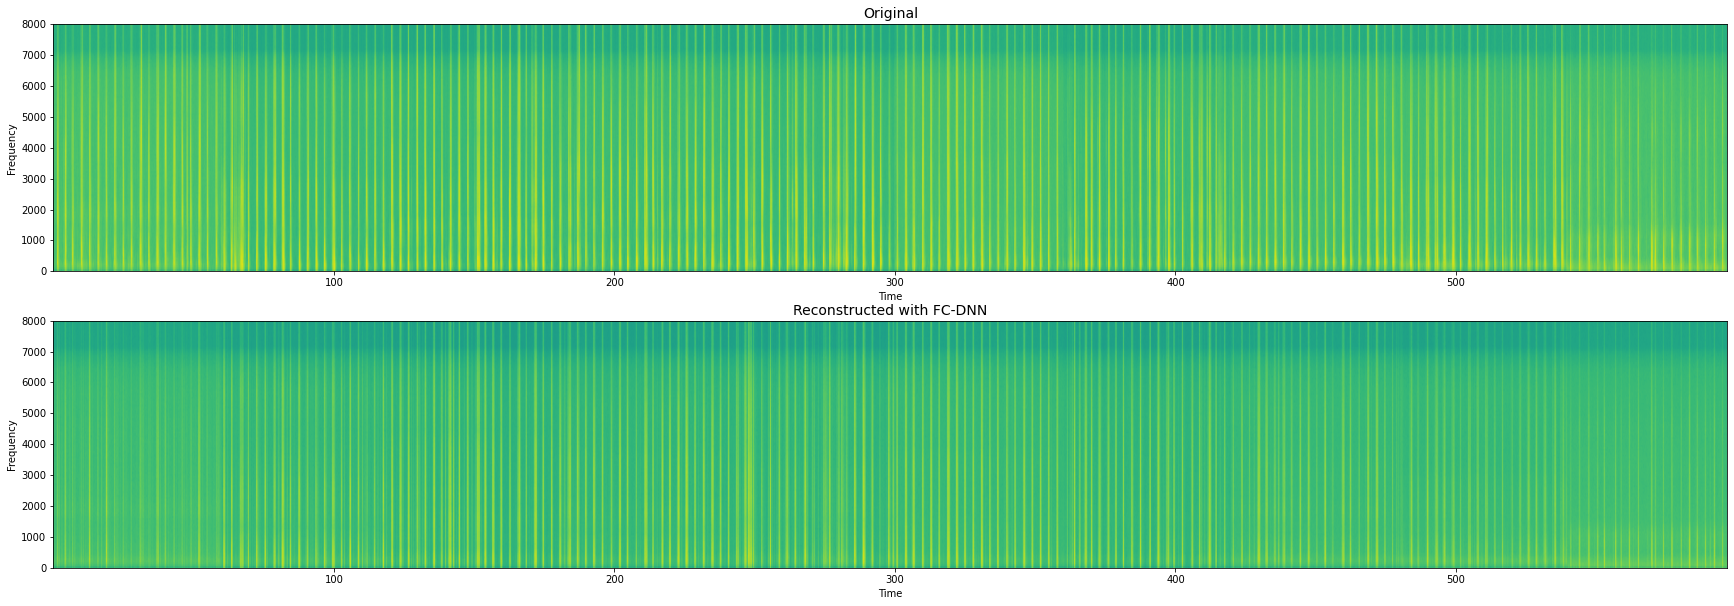

In [ ]:
# plotting the spectograms of the original audiofile and the reconstructed file
plt.figure(figsize = (30,10))
plt.subplot(211)
plt.specgram(orig, Fs=16000)
plt.title('Original', fontsize=14)
plt.xlabel('Time')
plt.ylabel('Frequency') 

plt.subplot(212)
plt.specgram(rec_fcdnn, Fs=16000)
plt.title('Reconstructed with FC-DNN', fontsize=14)
plt.xlabel('Time')
plt.ylabel('Frequency')

plt.show()